In [1]:
%matplotlib inline
import pylab
import pandas as pd
import glob
from collections import defaultdict
import sourmash
from sourmash.lca import lca_utils

In [2]:
sample_id='SRR606249'
#sample_id = 'p8808mo9'
#sample_id = 'p8808mo11'
outdir = 'outputs'


In [3]:
from IPython.display import Markdown as md
from IPython.display import display
md(f"# genome-grist gathergram for metagenome `{sample_id}`")

# genome-grist gathergram for metagenome `SRR606249`

## load mapping summary CSVs and gather CSV

In [4]:
# load gather CSV
gather_df = pd.read_csv(f'{outdir}/genbank/{sample_id}.x.genbank.gather.csv')

# names!
names_df = pd.read_csv(f'{outdir}/genbank/{sample_id}.genomes.info.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['name'].apply(fix_name)
names_df['genome_id'] = names_df['acc'].apply(fix_name)

In [5]:
# CTB bug FIXME - should this ever happen??
# this ensures that only rows that share genome_id are in all the dataframes
in_gather = set(gather_df.genome_id)
names_df = names_df[names_df.genome_id.isin(in_gather)]

# reassign index now that we've maybe dropped rows
gather_df.index = range(len(gather_df))
names_df.index = range(len(names_df))

assert len(names_df) == len(gather_df)

In [6]:
# re-sort names_df to match gather_df order, using matching genome_id column
names_df.set_index("genome_id")
names_df.reindex(index=gather_df["genome_id"])
_ = names_df.reset_index()

In [7]:
# load and parse lineages
lineage_files = glob.glob('../genome-grist/genbank_lineages/*.csv')

lineages_df = pd.DataFrame()

for filename in lineage_files:
    print(f"reading {filename}")
    this_df = pd.read_csv(filename)
    this_df = this_df[this_df.accession.isin(in_gather)]
    lineages_df = lineages_df.append(this_df)
    
lineages_df

reading ../genome-grist/genbank_lineages/viral_genbank_lineage.csv
reading ../genome-grist/genbank_lineages/protozoa_refseq_lineage.csv
reading ../genome-grist/genbank_lineages/bacteria_genbank_lineage.csv
reading ../genome-grist/genbank_lineages/protozoa_genbank_lineage.csv
reading ../genome-grist/genbank_lineages/fungi_genbank_lineage.csv
reading ../genome-grist/genbank_lineages/archaea_genbank_lineage.csv
reading ../genome-grist/genbank_lineages/viral_refseq_lineage.csv
reading ../genome-grist/genbank_lineages/bacteria_refseq_lineage.csv
reading ../genome-grist/genbank_lineages/archaea_refseq_lineage.csv
reading ../genome-grist/genbank_lineages/fungi_refseq_lineage.csv


,accession,taxid,superkingdom,phylum,class,order,family,genus,species,strain
151,GCA_000018565,316274,Bacteria,Chloroflexi,Chloroflexia,Herpetosiphonales,Herpetosiphonaceae,Herpetosiphon,Herpetosiphon aurantiacus,Herpetosiphon aurantiacus DSM 785
368,GCA_000008185,243275,Bacteria,Spirochaetes,Spirochaetia,Spirochaetales,Spirochaetaceae,Treponema,Treponema denticola,Treponema denticola ATCC 35405
55913,GCA_003450455,275,Bacteria,Deinococcus-Thermus,Deinococci,Thermales,Thermaceae,Thermus,Thermus sp.,NaN
74438,GCA_000195675,257310,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Alcaligenaceae,Bordetella,Bordetella bronchiseptica,Bordetella bronchiseptica RB50
75827,GCA_003054575,264203,Bacteria,Proteobacteria,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Zymomonas,Zymomonas mobilis,Zymomonas mobilis subsp. mobilis ZM4 = ATCC 31821
...,...,...,...,...,...,...,...,...,...,...
618,GCA_000016385,340102,Archaea,Crenarchaeota,Thermoprotei,Thermoproteales,Thermoproteaceae,Pyrobaculum,Pyrobaculum arsenaticum,Pyrobaculum arsenaticum DSM 13514
635,GCA_000008085,228908,Archaea,Nanoarchaeota,NaN,Nanoarchaeales,Nanoarchaeaceae,Nanoarchaeum,Nanoarchaeum equitans,Nanoarchaeum equitans Kin4-M
636,GCA_000017945,453591,Archaea,Crenarchaeota,Thermoprotei,Desulfurococcales,Desulfurococcaceae,Ignicoccus,Ignicoccus hospitalis,Ignicoccus hospitalis KIN4/I
655,GCA_000015805,410359,Archaea,Crenarchaeota,Thermoprotei,Thermoproteales,Thermoproteaceae,Pyrobaculum,Pyrobaculum calidifontis,Pyrobaculum calidifontis JCM 11548


In [8]:
# build a new dataframe that has a single column of lineages in it
def make_combined_lineage(row):
    x = []
    for rank in ('superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'):
        name = getattr(row, rank)
        # turn NaN/empty into ''
        if pd.isnull(name):
            name = ''
        x.append(lca_utils.LineagePair(rank, name))
    return dict(genome_id=row.accession, combined_lineage=tuple(x))

lineages2_df = lineages_df.apply(make_combined_lineage, axis=1, result_type='expand')

lineages2_df.set_index("genome_id")
lineages2_df.reindex(index=gather_df["genome_id"])
_ = lineages2_df.reset_index()

In [9]:
# build a merged df that contains stuff from gather_df
merged_lin_df = gather_df.merge(lineages2_df[['genome_id','combined_lineage']], on='genome_id', how='left')

merged_lin_df[["genome_id", "name", "combined_lineage"]]

,genome_id,name,combined_lineage
0,GCA_000013645,GCA_000013645.1 Paraburkholderia xenovorans LB...,"((superkingdom, Bacteria), (phylum, Proteobact..."
1,GCA_000009705,GCA_000009705.1 Nostoc sp. PCC 7120 = FACHB-41...,"((superkingdom, Bacteria), (phylum, Cyanobacte..."
2,GCA_000196115,GCA_000196115.1 Rhodopirellula baltica SH 1 st...,"((superkingdom, Bacteria), (phylum, Planctomyc..."
3,GCA_000018565,GCA_000018565.1 Herpetosiphon aurantiacus DSM ...,"((superkingdom, Bacteria), (phylum, Chloroflex..."
4,GCA_002959695,GCA_002959695.1 Bacteroides thetaiotaomicron s...,"((superkingdom, Bacteria), (phylum, Bacteroide..."
...,...,...,...
68,GCA_000507765,GCA_000507765.1 Streptococcus parasanguinis CC...,"((superkingdom, Bacteria), (phylum, Firmicutes..."
69,GCA_003228185,GCA_003228185.1 Synechococcus sp. PCC 7002 x M...,"((superkingdom, Bacteria), (phylum, Cyanobacte..."
70,GCA_900115135,GCA_900115135.1 Proteiniclasticum ruminis stra...,"((superkingdom, Bacteria), (phylum, Firmicutes..."
71,GCA_000009565,GCA_000009565.2 Escherichia coli BL21(DE3) str...,"((superkingdom, Bacteria), (phylum, Proteobact..."


Text(0, 0.5, 'f_unique_to_query, as %')

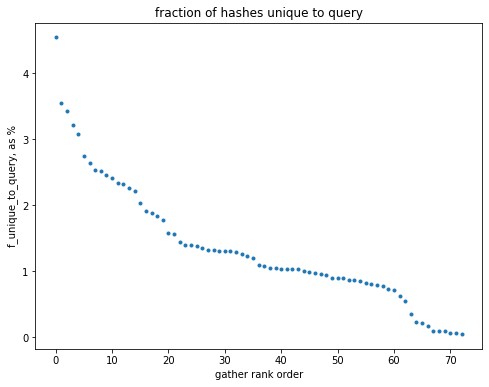

In [10]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df["f_unique_to_query"]*100, '.')

pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

## Taxonomy stuff

In [11]:
# create function that aggregates various pieces of information by rank & builds a new df
def aggregate_by_rank(df, rank):
    # first, build all the counts
    unique_intersect_by_rank = defaultdict(int)
    best_hashes_by_rank = {}

    def sum_unique(row):
        lin = row.combined_lineage
        if pd.isnull(lin):
            lin = []
        unique_hashes = row.unique_intersect_bp

        for rank in ('superkingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'):
            poplin = lca_utils.pop_to_rank(lin, rank)
            unique_intersect_by_rank[poplin] += unique_hashes
            
            best_hashes = best_hashes_by_rank.get(poplin, 0)
            if best_hashes < unique_hashes:
                best_hashes_by_rank[poplin] = unique_hashes

    df.apply(sum_unique, axis=1)

    # now do the sorting etc.
    rank_counts = []
    for lin, bp in sorted(unique_intersect_by_rank.items(), key=lambda x: -x[1]):
        if lin and lin[-1].rank == rank:
            
            if rank == 'species':
                name = lin[-1].name
                name = f'{name} ({lin[0].name})'
            else:
                name = lca_utils.display_lineage(lin)

            rank_counts.append(dict(name=name, hashes=bp,
                                    best_hashes=best_hashes_by_rank[lin],
                                    lineage=lin))

    return pd.DataFrame(rank_counts)

test_df = aggregate_by_rank(merged_lin_df, 'species')

In [12]:
for rank in lca_utils.taxlist(include_strain=False):
    print(f'computing and saving for {rank}')
    rank_counts_df = aggregate_by_rank(merged_lin_df, rank)
    rank_counts_df.to_csv(f'podar-dna-{rank}.csv')

computing and saving for superkingdom
computing and saving for phylum
computing and saving for class
computing and saving for order
computing and saving for family
computing and saving for genus
computing and saving for species


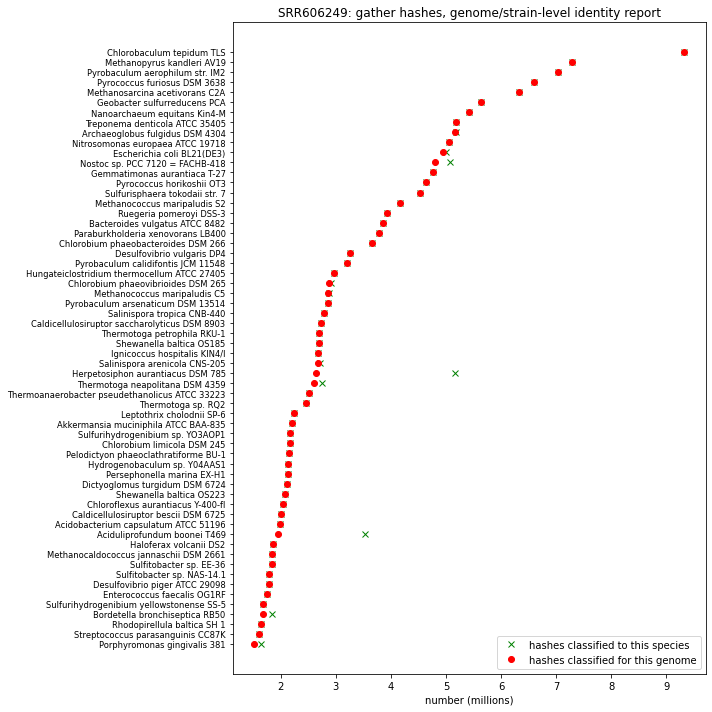

In [13]:
pylab.figure(num=None, figsize=(10, 10))

plot_df = gather_df[:60]
labels_df = names_df[:60]

pylab.plot(plot_df.intersect_bp / 1e6, plot_df.iloc[::-1].index, 'gx', label='hashes classified to this species')
pylab.plot(plot_df.unique_intersect_bp / 1e6, plot_df.iloc[::-1].index, 'ro', label='hashes classified for this genome')

positions = list(plot_df.index)
labels = list(reversed(labels_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('number (millions)')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes, genome/strain-level identity report')
pylab.tight_layout()

pylab.savefig(f'/tmp/gathergram-{sample_id}.hashes.png')

saving to /tmp/gathergram-species-SRR606249.png


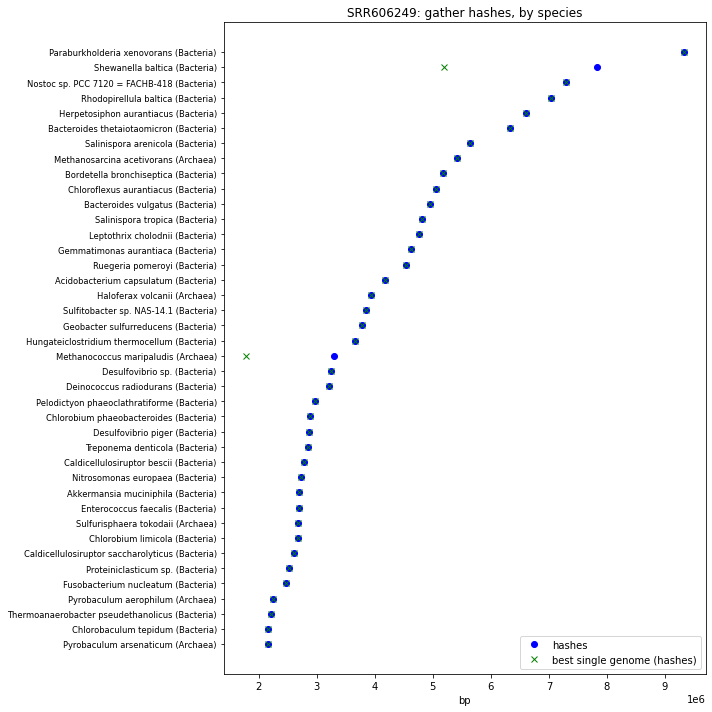

In [14]:
rank = 'species'

pylab.figure(num=None, figsize=(10, 10))

rank_counts_df = aggregate_by_rank(merged_lin_df, rank)
rank_counts_df.to_csv(f'podar-dna-{rank}.csv')

plot_df = rank_counts_df[:40]
pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.best_hashes, plot_df.iloc[::-1].index, 'gx', label='best single genome (hashes)')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('bp')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes, by {rank}')
pylab.tight_layout()

figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
print(f'saving to {figname}')
pylab.savefig(figname)

saving to /tmp/gathergram-genus-SRR606249.png


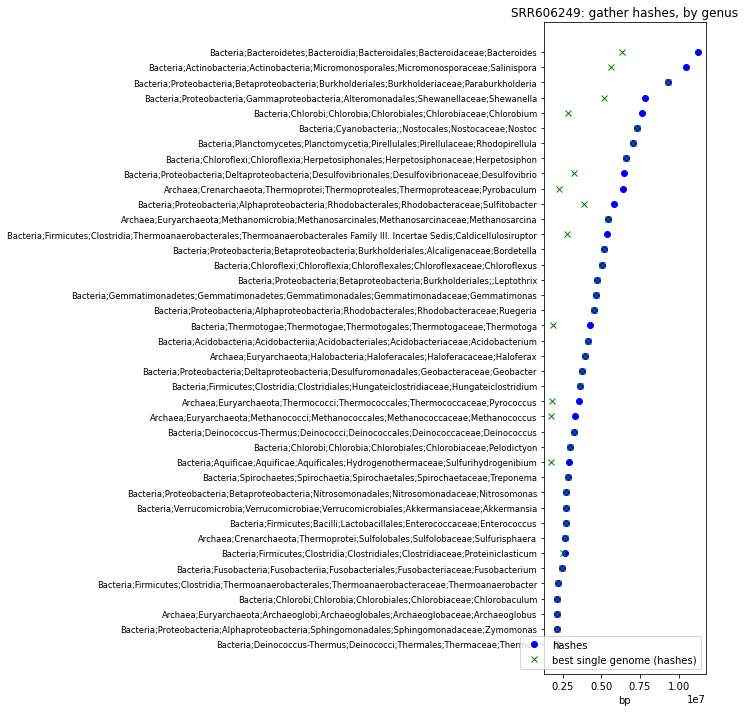

In [15]:
rank = 'genus'

pylab.figure(num=None, figsize=(10, 10))

rank_counts_df = aggregate_by_rank(merged_lin_df, rank)
rank_counts_df.to_csv(f'podar-dna-{rank}.csv')

plot_df = rank_counts_df[:40]
pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.best_hashes, plot_df.iloc[::-1].index, 'gx', label='best single genome (hashes)')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('bp')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes, by {rank}')
pylab.tight_layout()

figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
print(f'saving to {figname}')
pylab.savefig(figname)

saving to /tmp/gathergram-phylum-SRR606249.png


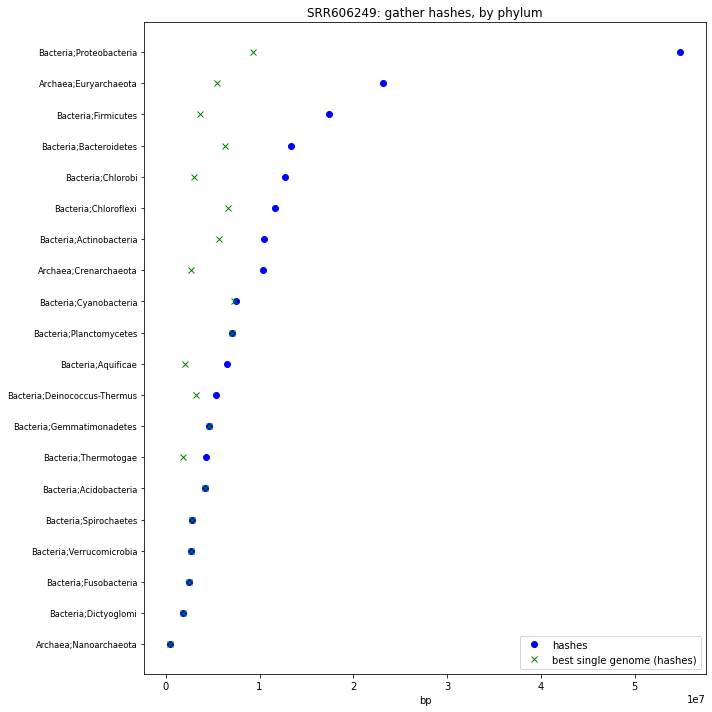

In [16]:
rank = 'phylum'

pylab.figure(num=None, figsize=(10, 10))

rank_counts_df = aggregate_by_rank(merged_lin_df, rank)
rank_counts_df.to_csv(f'podar-dna-{rank}.csv')

plot_df = rank_counts_df[:40]
pylab.plot(plot_df.hashes, plot_df.iloc[::-1].index, 'bo', label='hashes')
pylab.plot(plot_df.best_hashes, plot_df.iloc[::-1].index, 'gx', label='best single genome (hashes)')

positions = list(plot_df.index)
labels = list(reversed(plot_df.name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('bp')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes, by {rank}')
pylab.tight_layout()

figname = f'/tmp/gathergram-{rank}-{sample_id}.png'
print(f'saving to {figname}')
pylab.savefig(figname)